# Simple FEM-BEM Coupling for the Helmholtz Equation

## Background

<i>For this problem, you will need FEniCS installed alongside BEM++. If FEniCS is not available on your system you can use the virtual machine image from www.bempp.org</i>

In this tutorial we will solve the problem of a wave travelling through a unit cube, $\Omega = [0,1]^3$ with different material parameters than the surrounding homogeneous medium. The incident wave is given by

$$
u^\text{inc}(\mathbf{x})=e^{i k \mathbf{x}\cdot\mathbf{d}},
$$

where $\mathbf{x}=(x,y,z)^t$ and $\mathbf{d}$ is the direction of the incident wave. In the implementation, $\mathbf{d} = \frac{1}{\sqrt{3}}(1,1,1)^t$.

The PDE is:

$$
\Delta u + n(\mathbf{x})^2 k^2 u = 0, \quad \text{ in } \Omega\\
\Delta u + k^2 u = 0, \quad \text{ in } \mathbb{R}^3 \backslash \Omega
$$

In this example we use 

$$
n(x) = .5
$$
Since the interior wavenumber is constant one could have also used a BEM/BEM coupling approach. However, here we demonstrate the use of FEM for the interior problem via the <a href='http://fenicsproject.org/' target='new'>FEniCS</a> finite element package.

### FEM Part

In $\Omega$, the FEM part is formulated as

$$
\int_\Omega \nabla u\cdot\nabla v -k^2\int_\Omega n^2uv - \int_{d\Omega} v\frac{\partial u}{\partial n} = 0,
$$

or

$$
\langle\nabla u,\nabla v\rangle_\Omega - k^2\langle n^2u,v\rangle_\Omega - \langle \lambda,v\rangle_\Gamma=0,
$$

where $\lambda=\frac{\partial u}{\partial n}$.

Later, we will write this as

$$
Au-k^2 Mu-M_\Gamma \lambda = 0
$$

### BEM Part

In $\mathbb{R}^3 \backslash \Omega$, $u = u^\text{inc}+u^\text{s}$, where $u^\text{inc}$ is the incident wave and $u^\text{s}$ is the scattered wave. As given in <i>Integral Equation Methods in Scattering Theory</i> by D. Colton and R. Kress,

$$
0 = \mathcal{K}u^\text{inc}-\mathcal{V}\frac{\partial u^{inc}}{\partial n}
$$
where $\mathcal{K}$ is the double layer potential and $\mathcal{V}$ the single layer potential.

and

$$
u^\text{s} = \mathcal{K}u^\text{s}-\mathcal{V}\frac{\partial u^{s}}{\partial n},
$$

where $\mathcal{V}$ and $\mathcal{K}$ are the single and double layer potentials respectively. Adding these, we get

$$
u^\text{s} = \mathcal{K}u-\mathcal{V}\lambda.
$$

This will be used to find $u^\text{s}$ for plotting later.

Taking the trace on the boundary gives

$$
u-u^\text{inc} = \frac{1}{2}u + Ku-V\lambda,
$$

where again $\lambda=\frac{\partial u}{\partial n}$. This rearranges to

$$
u^\text{inc} = \left(\frac{1}{2}I-K\right)u+V\lambda.
$$

### Full Formulation

The full formulation is

$$
\begin{bmatrix}
    A-k^2 M & -M_\Gamma\\
    \frac{1}{2}I-K & V
\end{bmatrix}
\begin{bmatrix}
    u\\
    \lambda
\end{bmatrix}
=
\begin{bmatrix}
    0\\
    u^\text{inc}
\end{bmatrix}.
$$

This formulation is not stable for all frequencies due to the possibility of interior resonances. But it is sufficient for this example and serves as a blueprint for more complex formulations.

## Implementation

Import dolfin, the FEniCS python library, BEM++ and Numpy

In [12]:
import dolfin
import bempp.api
import numpy as np

Set the wavenumber ``k`` and the direction ``d`` of the incoming wave.

In [13]:
k = 6.
d = np.array([1., 1., 1])
d /= np.linalg.norm(d)

Create a FEniCS mesh. The boundary mesh will be extracted from this.

A mesh could be created from a file changing this line to

    mesh = dolfin.Mesh('/path/to/file.xml')

In [14]:
mesh = dolfin.UnitCubeMesh(10, 10, 10)

Make the FEniCS and BEM++ function spaces.

The function coupling.fenics_to_bempp_trace_date will extract the trace space from the FEniCS space and create the matrix (trace_matrix) which maps between the dofs in FEniCS and BEM++.

In [15]:
from bempp.api import fenics_interface

fenics_space = dolfin.FunctionSpace(mesh,"CG",1)
trace_space, trace_matrix  = fenics_interface.coupling.fenics_to_bempp_trace_data(fenics_space)
bempp_space = bempp.api.function_space(trace_space.grid,"DP",0)

print("FEM DOFs (Degrees of Freedom): {0}".format(mesh.num_vertices()))
print("BEM DOFs: {0}".format(bempp_space.global_dof_count))

DEBUG:FFC:Reusing form from cache.


FEM DOFs (Degrees of Freedom): 1331
BEM DOFs: 1200


Create the operators.

In [16]:
id_op = bempp.api.operators.boundary.sparse.identity(trace_space, bempp_space, bempp_space)
mass = bempp.api.operators.boundary.sparse.identity(bempp_space, bempp_space, trace_space)
dlp = bempp.api.operators.boundary.helmholtz.double_layer(trace_space, bempp_space, bempp_space, k)
slp = bempp.api.operators.boundary.helmholtz.single_layer(bempp_space, bempp_space, bempp_space, k)

Create the FEniCS function spaces and the function n.

In [17]:
u = dolfin.TrialFunction(fenics_space)
v = dolfin.TestFunction(fenics_space)
n = .5

Make the vector on the right hand side of the formulation.

In [18]:
def u_inc(x, n, domain_index, result):
    result[0] = np.exp(1j*k*np.dot(x, d))
u_inc = bempp.api.GridFunction(bempp_space, fun=u_inc)

# The rhs from the FEM
rhs_fem = np.zeros(mesh.num_vertices())
# The rhs from the BEM
rhs_bem = u_inc.projections(bempp_space)
# The combined rhs
rhs = np.concatenate([rhs_fem, rhs_bem])

INFO:BEMPP:IDENTITY. START ASSEMBLY. Dim: (1200,1200). Assembly Type: sparse
INFO:BEMPP:IDENTITY. FINISHED ASSEMBLY. Time: 2.87E-03 sec.
INFO:BEMPP:IDENTITY. START ASSEMBLY. Dim: (1200,1200). Assembly Type: sparse
INFO:BEMPP:IDENTITY. FINISHED ASSEMBLY. Time: 2.59E-03 sec.


Create a BlockedLinearOperator containing all four parts of
$$
\begin{bmatrix}
    A-k^2 M & -M_\Gamma\\
    \frac{1}{2}I-K & V
\end{bmatrix}.
$$

In [19]:
from bempp.api.utils.linear_operator import aslinearoperator
from bempp.api.fenics_interface import FenicsOperator

blocked = bempp.api.BlockedDiscreteOperator(2, 2)


trace_op = aslinearoperator(trace_matrix)

A = FenicsOperator((dolfin.inner(dolfin.nabla_grad(u),
                                dolfin.nabla_grad(v)) -k**2 * n**2 * u * v) * dolfin.dx)

blocked[0, 0] = A.weak_form()
blocked[0, 1] = -trace_op.adjoint() * mass.weak_form()
blocked[1, 0] = (.5 * id_op - dlp).weak_form()*trace_op
blocked[1, 1] = slp.weak_form()

DEBUG:FFC:Reusing form from cache.
INFO:BEMPP:IDENTITY. START ASSEMBLY. Dim: (1200,602). Assembly Type: sparse
INFO:BEMPP:IDENTITY. FINISHED ASSEMBLY. Time: 3.98E-03 sec.
INFO:BEMPP:IDENTITY. START ASSEMBLY. Dim: (602,1200). Assembly Type: sparse
INFO:BEMPP:IDENTITY. FINISHED ASSEMBLY. Time: 4.31E-03 sec.
INFO:BEMPP:DLP. START ASSEMBLY. Dim: (602,1200). Assembly Type: hmat
INFO:BEMPP:DLP. FINISHED ASSEMBLY. Time: 4.39E+00 sec. Mem Size (Mb): 2.50E+00. Compression: 2.27E-01
INFO:BEMPP:SLP. START ASSEMBLY. Dim: (1200,1200). Assembly Type: hmat
INFO:BEMPP:SLP. FINISHED ASSEMBLY. Time: 2.35E+00 sec. Mem Size (Mb): 3.93E+00. Compression: 1.79E-01


Solve the system, then split the solution into the parts assosiated with u and &lambda;. For an efficient solve, preconditioning is required.

In [20]:
from scipy.sparse.linalg import LinearOperator

# Compute the sparse inverse of the Helmholtz operator
# Although it is not a boundary operator we can use
# the SparseInverseDiscreteBoundaryOperator function from
# BEM++ to turn its LU decomposition into a linear operator.
P1 = bempp.api.InverseSparseDiscreteBoundaryOperator(blocked[0,0].sparse_operator.tocsc())

# For the Laplace slp we use a simple mass matrix preconditioner. 
# This is sufficient for smaller low-frequency problems.
P2 = bempp.api.InverseSparseDiscreteBoundaryOperator(
    bempp.api.operators.boundary.sparse.identity(bempp_space, bempp_space, bempp_space).weak_form())

# Create a block diagonal preconditioner object using the Scipy LinearOperator class
def apply_prec(x):
    """Apply the block diagonal preconditioner"""
    m1 = P1.shape[0]
    m2 = P2.shape[0]
    n1 = P1.shape[1]
    n2 = P2.shape[1]
    
    res1 = P1.dot(x[:n1])
    res2 = P2.dot(x[n1:])
    return np.concatenate([res1, res2])
p_shape = (P1.shape[0]+P2.shape[0], P1.shape[1]+P2.shape[1])
P = LinearOperator(p_shape, apply_prec, dtype=np.dtype('complex128'))

# Create a callback function to count the number of iterations
it_count = 0
def count_iterations(x):
    global it_count
    it_count += 1

from scipy.sparse.linalg import gmres
soln, info = gmres(blocked, rhs, M=P, callback=count_iterations)

soln_fem = soln[:mesh.num_vertices()]
soln_bem = soln[mesh.num_vertices():]

print("Number of iterations: {0}".format(it_count))

INFO:BEMPP:IDENTITY. START ASSEMBLY. Dim: (1200,1200). Assembly Type: sparse
INFO:BEMPP:IDENTITY. FINISHED ASSEMBLY. Time: 3.11E-03 sec.


Number of iterations: 380


Make FEniCS and BEM++ functions from solution and save them to files.

The FEniCS functions can be viewed with <a href='http://www.paraview.org/' target='new'>paraview</a>. The BEM++ functions can be viewed with <a href='http://geuz.org/gmsh/' target='new'>gmsh</a>.

In [21]:
# Store the real part of the FEM solution
u=dolfin.Function(fenics_space)
u.vector()[:]=np.ascontiguousarray(np.real(soln_fem))
dolfin.File("u.pvd") << u

# Solution function with dirichlet data on the boundary
dirichlet_data = trace_matrix*soln_fem
dirichlet_fun = bempp.api.GridFunction(trace_space, coefficients=dirichlet_data)

# Solution function with Neumann data on the boundary
neumann_fun = bempp.api.GridFunction(bempp_space, coefficients=soln_bem)

# Export the solutions
bempp.api.export(grid_function=dirichlet_fun, file_name='boundary_data.msh', data_label='solution',
                transformation=np.real)
bempp.api.export(grid_function=neumann_fun, file_name='boundary_normal_data.msh', data_label='solution',
                transformation=np.real)

Evaluate the solution on the slice $z=0.5$ and plot it. For the exterior domain, we use

$$
u^\text{s} = \mathcal{K}u-\mathcal{V}\frac{\partial u}{\partial n}.
$$

INFO:BEMPP:POTENTIAL OPERATOR ASSEMBLY START. Number of points: 37500. Space dimension: 1200. Assembly type: hmat 
INFO:BEMPP:FINISHED POTENTIAL OPERATOR ASSEMBLY. Time: 9.01E+00 sec.
INFO:BEMPP:POTENTIAL OPERATOR ASSEMBLY START. Number of points: 37500. Space dimension: 602. Assembly type: hmat 
INFO:BEMPP:FINISHED POTENTIAL OPERATOR ASSEMBLY. Time: 3.65E+01 sec.


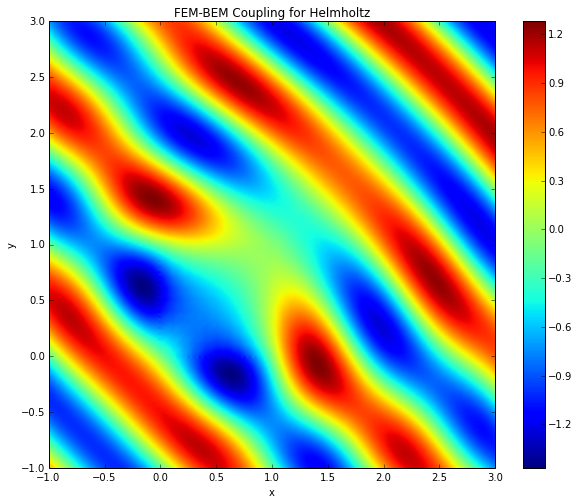

In [22]:
# The next command ensures that plots are shown within the IPython notebook
%matplotlib inline

# Reduce the H-Matrix accuracy since the evaluation of potentials for plotting
# needs not be very accurate.
bempp.api.global_parameters.hmat.eps = 1E-2

Nx=200
Ny=200
xmin, xmax, ymin, ymax=[-1,3,-1,3]
plot_grid = np.mgrid[xmin:xmax:Nx*1j,ymin:ymax:Ny*1j]
points = np.vstack((plot_grid[0].ravel(), plot_grid[1].ravel(), np.array([0.5]*plot_grid[0].size)))
plot_me = np.zeros(points.shape[1], dtype=np.complex128)

x,y,z = points
bem_x = np.logical_not((x>0)*(x< 1)*(y > 0)*(y < 1)*(z > 0)*(z< 1))

slp_pot= bempp.api.operators.potential.helmholtz.single_layer(bempp_space,points[:,bem_x],k)
dlp_pot= bempp.api.operators.potential.helmholtz.double_layer(trace_space,points[:,bem_x],k)

plot_me[bem_x] += np.exp(1j*k*(points[0,bem_x]*d[0]+points[1,bem_x]*d[1]+points[2,bem_x]*d[2]))
plot_me[bem_x] += dlp_pot.evaluate(dirichlet_fun).flat
plot_me[bem_x] -= slp_pot.evaluate(neumann_fun).flat

fem_points = points[:,np.logical_not(bem_x)].transpose()
fem_val = np.zeros(len(fem_points))
for p,point in enumerate(fem_points):
    result = np.zeros(1)
    u.eval(result,point)
    fem_val[p] = result[0]

plot_me[np.logical_not(bem_x)] += fem_val

plot_me = plot_me.reshape((Nx,Ny))

plot_me = plot_me.transpose()[::-1]

# Plot the image
from matplotlib import pyplot as plt
fig=plt.figure(  figsize =(10, 8))
plt.imshow(np.real(plot_me),extent=[xmin,xmax,ymin,ymax])
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.title("FEM-BEM Coupling for Helmholtz")
plt.show()